# Asteroid Light Curves Examples - Part 2

This notebook uses the same asteroid light curve data as part 1 but looks at several unsupervised techniques.

## Objectives

- Understand several techniques that might be available when you have little or no labeled data.

In [1]:
# Path to the ALCDEF_ALL dataset downloaded from http://alcdef.org
# Download the full archive as a .zip file. Extract its contents to this
# directory. It should be ~14K .txt files.
data_dir = 'data/ALCDEF_ALL'

# Discard any light curves with fewer than this many samples
min_samples = 100

# Resample light curves to common number of samples
nb_samples = 100

# Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from glob import glob
from scipy.signal import resample
from collections import Counter

import random


from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Reshape
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, Input, UpSampling1D

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import umap

import pandas as pd
import seaborn as sns

from ml4ssa_utils import visualize_embedding, load_alcdef_data, plot_alcdef_examples, normalize_features, plot_confusion_matrix

Using TensorFlow backend.


# Load Dataset

Load data from Astroid Lightcurve Photometry Database (http://alcdef.org/)

In [3]:
data = load_alcdef_data(
    data_dir=data_dir,
    min_samples=min_samples,
    resample_to=nb_samples,
    reduce_to_top=60 # keeping the 60 most common object types
)

# Visualize Raw Features

In [4]:
X = np.stack([item['DATA_RESAMPLED'][:,1] for item in data])
X.shape
names = list(set([item['OBJECTNAME'] for item in data]))

# Here we setup target values for the correct class but we won't actually use them
y = np.array([ names.index(item['OBJECTNAME']) for item in data ])

C:\Users\jpula\AppData\Local\Continuum\anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding 2 connected components using meta-embedding (experimental)
  n_components


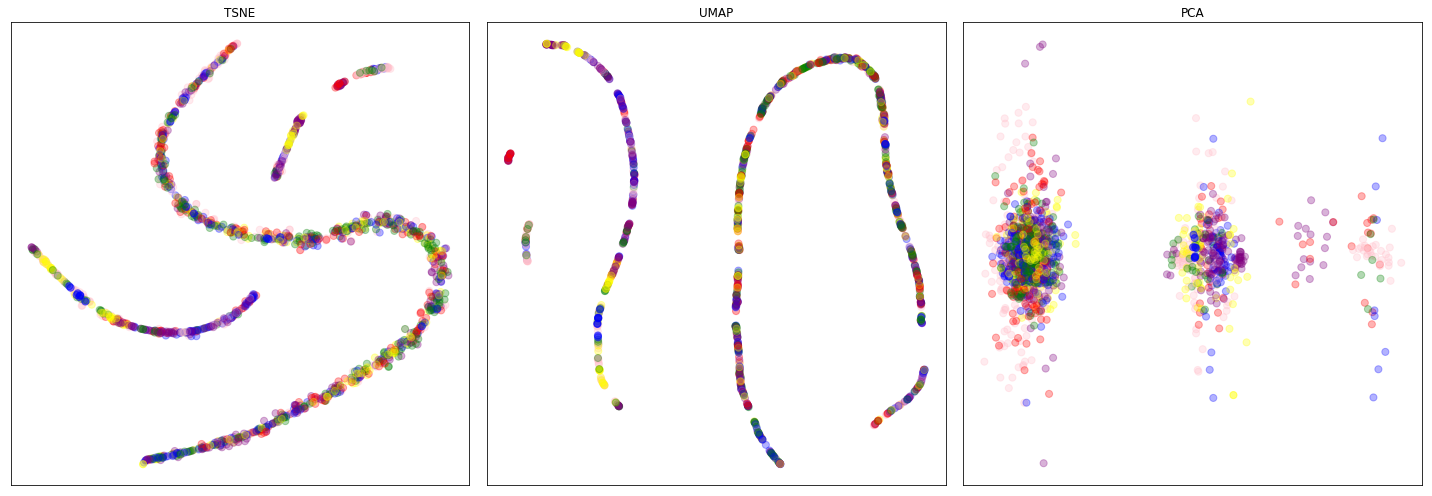

In [5]:
visualize_embedding(X, y)

# Self-Supervised Techniques

We often have access to features but few or no corresponding targets. In these cases, one powerful technique is called self-supervision. The setup usually involves taking (or sometimes making) features that you do not particularly care about and treating them as targets. The hope is that in learning to predict these targets you will have forced the network to learn something genuinly useful about the data.

## Example 1: Auto-Encoder

For example, an __auto-encoder__ is a neural network whose goal is to cover its input. To make that an interesting problem, the network topology is designed to have a low-dimensional choke point. By the nature of having this choke point, a trained auto-encoder must have learned an apposimate low-dimensional representation of your original data. 

In [6]:
nb_classes = len(names)

model = Sequential()
model.add(Conv1D(filters=8, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(filters=4, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(filters=4, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(filters=4, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2, padding='same'))

model.add(Conv1D(filters=4, kernel_size=3, activation='relu', padding='same'))
model.add(UpSampling1D(2))

model.add(Conv1D(filters=4, kernel_size=3, activation='relu', padding='same'))
model.add(UpSampling1D(2))
model.add(Conv1D(filters=4, kernel_size=3, activation='relu'))
model.add(UpSampling1D(2))
model.add(Conv1D(filters=8, kernel_size=3, activation='relu'))
model.add(UpSampling1D(2))
model.add(Conv1D(filters=1, kernel_size=3, activation='sigmoid', padding='same'))

model.compile(
    loss='mse',
    optimizer=Adam(lr=0.0001)
)

# keras is complaining that I need to evaluate the model before printing a summary
model.predict(np.zeros((16,100,1)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 8)            32        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 8)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 4)             100       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 25, 4)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 25, 4)             52        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 13, 4)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 13, 4)             52        
__________

In [7]:
# Prepare data to pass to model
repeats = 10
# The repeats value here is used to artifically increase the size of our training set.
# This forces keras to treat <repeats> passes through the training set as a single epoch and we
# get to avoid a huge number of progress bars and short-term variance in metrics.
train_features = normalize_features(X.repeat(repeats, axis=0))
# train_targets = to_categorical(y)

# The convolutional layers will expect a "channels" dimension at the end.
train_features = np.expand_dims(train_features, axis=-1)

train_targets = np.copy(train_features)

model.fit(
    train_features, train_targets,
    epochs=10,
    batch_size=1,
    verbose=16
)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


# Example 2: Unsupervised Feature Learning

The idea behind this example comes from [_Unsupervised Feature Learning via Non-Parametric Instance-level Discrimination_](https://arxiv.org/abs/1805.01978) (UC Berkeley, Chinese University of Hong Kong, Amazon Rekognition).

### Idea
- Train a network to discrimate between every one of your samples (possibly many 1000s of instances).
- Introduce a pinch-point in the algoritm so that it must learn a low-dimensional representation from which to do the discrimation.
- If the pinch-point is "sufficiently constrained", then the network will be encouraged to map "similar" examples near each other in latent space.  

In [22]:
nb_classes = len(names)

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=8, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)))
model.add(GlobalAveragePooling1D())
model.add(Dense(len(X)))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam'
)

# keras is complaining that I need to evaluate the model before printing a summary
model.predict(np.zeros((16,100,1)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 96, 64)            384       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 48, 64)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 44, 32)            10272     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 22, 32)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 18, 8)             1288      
_________________________________________________________________
global_average_pooling1d_2 ( (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1609)              14481     
Total para

In [23]:
# Prepare data to pass to model
repeats = 1
# The repeats value here is used to artifically increase the size of our training set.
# This forces keras to treat <repeats> passes through the training set as a single epoch and we
# get to avoid a huge number of progress bars and short-term variance in metrics.
train_features = normalize_features(X.repeat(repeats, axis=0))
train_targets = np.array(range(len(X))).repeat(repeats, axis=0)

# The convolutional layers will expect a "channels" dimension at the end.
train_features = np.expand_dims(train_features, axis=-1)

model.fit(
    train_features, train_targets,
    epochs=20,
    batch_size=16,
    verbose=1
)

Epoch 1/20
1609/1609 [==============================] - 28s 17ms/step - loss: 8.2619
Epoch 2/20
1609/1609 [==============================] - 27s 17ms/step - loss: 7.6011
Epoch 3/20
1609/1609 [==============================] - 26s 16ms/step - loss: 9.7651
Epoch 4/20
1609/1609 [==============================] - 26s 16ms/step - loss: 7.5624
Epoch 5/20
1609/1609 [==============================] - 27s 17ms/step - loss: 7.5341
Epoch 6/20
1609/1609 [==============================] - 29s 18ms/step - loss: 7.5203
Epoch 7/20
1609/1609 [==============================] - 27s 17ms/step - loss: 7.5087
Epoch 8/20
1609/1609 [==============================] - 27s 17ms/step - loss: 7.5013
Epoch 9/20
1609/1609 [==============================] - 26s 16ms/step - loss: 7.4920
Epoch 10/20
1609/1609 [==============================] - 26s 16ms/step - loss: 7.4842 2s - l
Epoch 11/20
1609/1609 [==============================] - 26s 16ms/step - loss: 7.4774
Epoch 12/20
1609/1609 [==============================] -

In [24]:
# Information Retrevial Metrics

# Measure how well we are able to retrieve examples from the same category
def find_closest_k(X, x, k=10):
    '''Returns the indices for the closest k vectors in X to x.'''
    return np.argpartition(np.linalg.norm(X-x,axis=1),k)

# Here we extract the intermediate features/activations from the layer named penultimate
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)
X_embedding = intermediate_layer_model.predict(train_features[:len(X)])

In [25]:
cm = np.zeros((nb_classes, nb_classes))
for ndx, x in enumerate(X_embedding):
    
    # Find the closest item in latent space that isn't the query term
    ndxs = find_closest_k(X_embedding, x, k=2)
    neighbor = [ tmp for tmp in ndxs if tmp != ndx ][0]

    query_cls = names.index(data[ndx]['OBJECTNAME'])
    neighbor_cls = names.index(data[neighbor]['OBJECTNAME'])
    
    cm[query_cls, neighbor_cls] += 1

In [26]:
class_counts = np.sum(to_categorical(y), axis=0)
class_proportions = class_counts / np.sum(class_counts)
max_proportion = np.max(class_proportions)
random_performance = 1./nb_classes
nearest_neighbor_performance = np.trace(cm)/np.sum(cm)

print('Accuracy of random classifier: {:.2f}'.format(random_performance))
print('Accuracy of mode-classifier: {:.2f}'.format(max_proportion))
print('Accuracy of UFL-based nearest neighbor classification: {:.2f}'.format(nearest_neighbor_performance))

Accuracy of random classifier: 0.02
Accuracy of mode-classifier: 0.05
Accuracy of UFL-based nearest neighbor classification: 0.14
